In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from helper_functions import create_tensorboard_callback, create_model_checkpoint_callback

/Users/chientm/miniconda3/envs/sandbox/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
df = pd.read_csv('data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', parse_dates=['Date'], index_col=['Date'])
print(df.shape)
df.head()

(2787, 5)


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
price_df = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
price_df

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


## Train-test split

In [4]:
split_size = int(0.8 * len(price_df))
X_train, y_train = price_df.index[:split_size].values, price_df.Price[:split_size].values
X_test, y_test = price_df.index[split_size:].values, price_df.Price[split_size:].values
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2229,), (2229,), (558,), (558,))

In [5]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

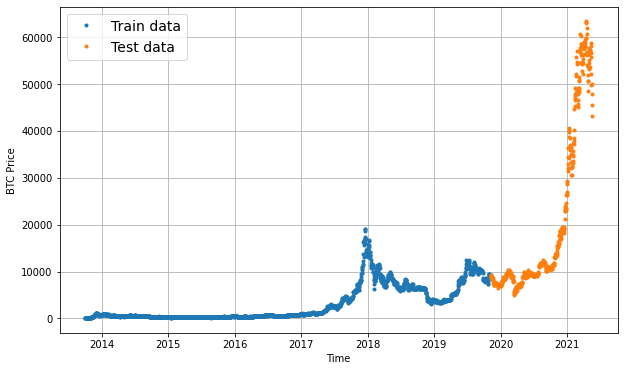

In [6]:
plt.figure(figsize=(10, 6))
plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, label='Test data')

## Model 0: Naive model

Use previous value as predicted value: $$\hat{y}_{t} = y_{t-1}$$

In [7]:
model0_pred = y_test[:-1]

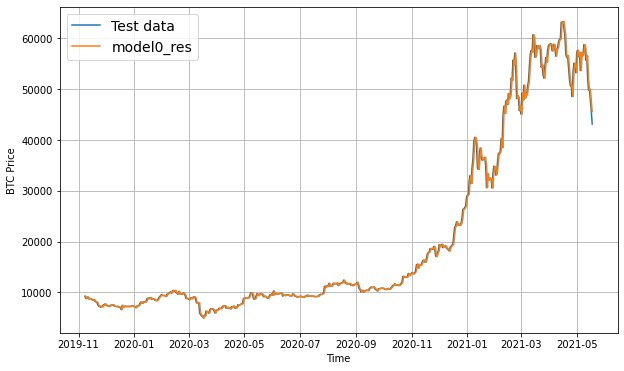

In [8]:
plt.figure(figsize=(10, 6))
plot_time_series(X_test, y_test, format='-', label='Test data')
plot_time_series(X_test[1:], model0_pred, format='-', label='model0_res')

### Evaluation

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae/mae_naive_no_season

def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    mae = tf.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    
    return {'mae': mae.numpy(), 'mse': mse.numpy(), 'rmse': rmse.numpy(), 'mape': mape.numpy(), 'mase': mase.numpy()}

In [11]:
model0_res = evaluate_preds(y_test[1:], model0_pred)
model0_res

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Windowing datasets

In [12]:
WINDOW_SIZE = 7
HORIZON = 1 # Number of predict value in the future

In [13]:
def get_labeled_window(x, horizon=HORIZON):
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labeled_window(windowed_array, horizon=horizon)

    return windows, labels

def split_windowed_data(windows, labels, test_size=0.2):
    split_size = int(len(windows) * (1 - test_size))
    train_windows, test_windows = windows[:split_size], windows[split_size:]
    train_labels, test_labels = labels[:split_size], labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [14]:
full_windows, full_labels = make_windows(price_df.Price.values)
full_windows.shape, full_labels.shape

((2780, 7), (2780, 1))

In [15]:
train_windows, test_windows, train_labels, test_labels = split_windowed_data(full_windows, full_labels)
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

## Model 1: Dense model with window=7, horizon=1

In [9]:
tb_callback1 = create_tensorboard_callback(dir_name='timeseries_logs/model_logs', experiment_name='model1_dense_window7_horizon1')
mc_callback1 = create_model_checkpoint_callback(save_path='timeseries_logs/model_checkpoint', model_name='model1_dense_window7_horizon1')

Saving TensorBoard log files to: timeseries_logs/model_logs/model1_dense_window7_horizon1/20220630-164735
Saving model checkpoint to: timeseries_logs/model_checkpoint/model1_dense_window7_horizon1


In [11]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='model_1')

model_1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_1.fit(train_windows, train_labels, epochs=100, verbose=1, batch_size=128, validation_data=(test_windows, test_labels),
            callbacks=[tb_callback1, mc_callback1])

Epoch 1/100
18/18 [==============================] - 0s 7ms/step - loss: 675.8509 - mae: 675.8509 - mse: 1820622.0000 - val_loss: 1914.5337 - val_mae: 1914.5337 - val_mse: 9701091.0000
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 228.4672 - mae: 228.4672 - mse: 243467.8594 - val_loss: 1047.6404 - val_mae: 1047.6404 - val_mse: 3689768.5000
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 183.8414 - mae: 183.8414 - mse: 173217.3594 - val_loss: 973.6600 - val_mae: 973.6600 - val_mse: 3131144.2500
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 169.4987 - mae: 169.4987 - mse: 154305.8906 - val_loss: 1016.3947 - val_mae: 1016.3947 - val_mse: 3116356.5000
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 165.1151 - mae: 165.1151 - mse: 145567.7188 - val_loss: 913.5350 - val_mae: 913.5350 - val_mse: 2765951.0000
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 159.8849 -

In [16]:
best_model_1 = tf.keras.models.load_model('timeseries_logs/model_checkpoint/model1_dense_window7_horizon1')
model1_pred = best_model_1.predict(test_windows)
model1_pred.shape, test_labels.shape

18/18 [==============================] - 1s 2ms/step


((556, 1), (556, 1))

In [17]:
model1_res = evaluate_preds(test_labels[:, 0], model1_pred[:, 0])
model1_res

{'mae': 566.1671,
 'mse': 1164192.9,
 'rmse': 1078.9777,
 'mape': 2.5417078,
 'mase': 0.9945988}

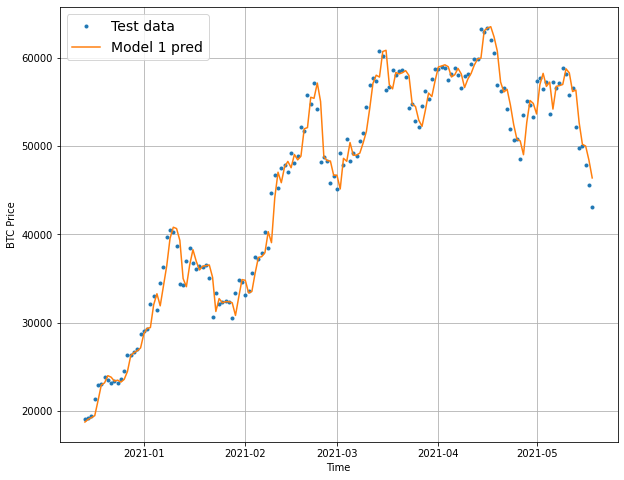

In [18]:
offset = 400
plt.figure(figsize=(10, 8))
plot_time_series(X_test[-len(test_windows):], test_labels[:, 0], start=offset, label='Test data')
plot_time_series(X_test[-len(test_windows):], model1_pred[:, 0], start=offset, format='-', label='Model 1 pred')

## Model 2: Dense model with window=30, horizon=1

In [19]:
full_windows, full_labels = make_windows(price_df.Price.values, window_size=30)
full_windows.shape, full_labels.shape

((2757, 30), (2757, 1))

In [20]:
train_windows, test_windows, train_labels, test_labels = split_windowed_data(full_windows, full_labels)
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [18]:
tb_callback2 = create_tensorboard_callback(dir_name='timeseries_logs/model_logs', experiment_name='model2_dense_window30_horizon1')
mc_callback2 = create_model_checkpoint_callback(save_path='timeseries_logs/model_checkpoint', model_name='model2_dense_window30_horizon1')

Saving TensorBoard log files to: timeseries_logs/model_logs/model2_dense_window30_horizon1/20220701-102618
Saving model checkpoint to: timeseries_logs/model_checkpoint/model2_dense_window30_horizon1


In [19]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='model_2')

model_2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_2.fit(train_windows, train_labels, epochs=100, verbose=1, batch_size=128, validation_data=(test_windows, test_labels),
            callbacks=[tb_callback2, mc_callback2])

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 634.4869 - mae: 634.4869 - mse: 1762154.1250 - val_loss: 1631.5061 - val_mae: 1631.5061 - val_mse: 7982404.5000
Epoch 2/100
18/18 [==============================] - 0s 19ms/step - loss: 276.3776 - mae: 276.3776 - mse: 386456.1562 - val_loss: 1159.8870 - val_mae: 1159.8870 - val_mse: 4634752.0000
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 214.7294 - mae: 214.7294 - mse: 229492.3594 - val_loss: 1405.5635 - val_mae: 1405.5635 - val_mse: 5177253.0000
Epoch 4/100
18/18 [==============================] - 0s 20ms/step - loss: 194.0423 - mae: 194.0423 - mse: 184537.6250 - val_loss: 1056.3992 - val_mae: 1056.3992 - val_mse: 3817577.2500
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 205.7588 - mae: 205.7588 - mse: 200364.9844 - val_loss: 1139.4312 - val_mae: 1139.4312 - val_mse: 3789305.5000
Epoch 6/100
18/18 [==============================] - 0s 20ms/step - loss: 19

In [21]:
best_model_2 = tf.keras.models.load_model('timeseries_logs/model_checkpoint/model2_dense_window30_horizon1')
model2_pred = best_model_2.predict(test_windows)
model2_pred.shape, test_labels.shape

18/18 [==============================] - 0s 865us/step


((552, 1), (552, 1))

In [22]:
model2_res = evaluate_preds(test_labels[:, 0], model2_pred[:, 0])
model2_res

{'mae': 593.4899,
 'mse': 1194405.6,
 'rmse': 1092.8887,
 'mape': 2.693717,
 'mase': 1.0374262}

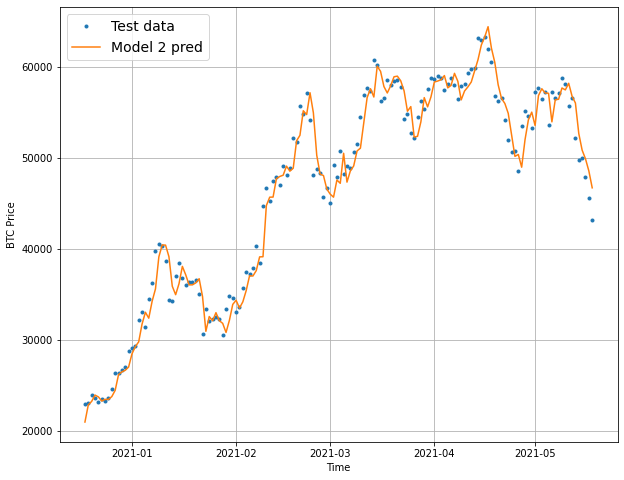

In [23]:
offset = 400
plt.figure(figsize=(10, 8))
plot_time_series(X_test[-len(test_windows):], test_labels[:, 0], start=offset, label='Test data')
plot_time_series(X_test[-len(test_windows):], model2_pred[:, 0], start=offset, format='-', label='Model 2 pred')

## Model 3: Dense model with window=30, horizon=7

In [24]:
HORIZON = 7
full_windows, full_labels = make_windows(price_df.Price.values, window_size=30, horizon=7)
full_windows.shape, full_labels.shape

((2751, 30), (2751, 7))

In [25]:
train_windows, test_windows, train_labels, test_labels = split_windowed_data(full_windows, full_labels)
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2200, 30), (551, 30), (2200, 7), (551, 7))

In [27]:
tb_callback3 = create_tensorboard_callback(dir_name='timeseries_logs/model_logs', experiment_name='model3_dense_window30_horizon7')
mc_callback3 = create_model_checkpoint_callback(save_path='timeseries_logs/model_checkpoint', model_name='model3_dense_window30_horizon7')

model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='model_3')

model_3.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_3.fit(train_windows, train_labels, epochs=100, verbose=1, batch_size=128, validation_data=(test_windows, test_labels),
            callbacks=[tb_callback3, mc_callback3])

Saving TensorBoard log files to: timeseries_logs/model_logs/model3_dense_window30_horizon7/20220701-110134
Saving model checkpoint to: timeseries_logs/model_checkpoint/model3_dense_window30_horizon7
Epoch 1/100
18/18 [==============================] - 1s 34ms/step - loss: 2255.9397 - mae: 2255.9397 - mse: 23345158.0000 - val_loss: 3024.4023 - val_mae: 3024.4023 - val_mse: 25290312.0000
Epoch 2/100
18/18 [==============================] - 0s 20ms/step - loss: 628.0568 - mae: 628.0568 - mse: 1718016.8750 - val_loss: 2965.6221 - val_mae: 2965.6221 - val_mse: 23918542.0000
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 429.3078 - mae: 429.3078 - mse: 858668.2500 - val_loss: 2082.9729 - val_mae: 2082.9729 - val_mse: 13011851.0000
Epoch 4/100
18/18 [==============================] - 0s 20ms/step - loss: 362.9915 - mae: 362.9915 - mse: 665089.2500 - val_loss: 1826.7491 - val_mae: 1826.7491 - val_mse: 10313997.0000
Epoch 5/100
18/18 [==============================] -

In [26]:
best_model_3 = tf.keras.models.load_model('timeseries_logs/model_checkpoint/model3_dense_window30_horizon7')
model3_pred = best_model_3.predict(test_windows)
model3_pred.shape, test_labels.shape

18/18 [==============================] - 0s 742us/step


((551, 7), (551, 7))

In [27]:
model3_res = evaluate_preds(test_labels, model3_pred)
model3_res

{'mae': 1231.0531,
 'mse': 5353183.0,
 'rmse': 1419.8928,
 'mape': 5.5976124,
 'mase': 2.19059}

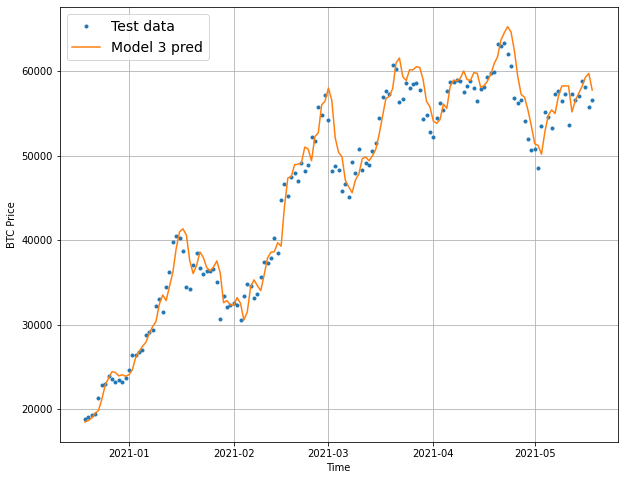

In [28]:
offset = 400
plt.figure(figsize=(10, 8))
plot_time_series(X_test[-len(test_windows):], test_labels[:, 0], start=offset, label='Test data')
plot_time_series(X_test[-len(test_windows):], tf.reduce_mean(model3_pred, axis=1), start=offset, format='-', label='Model 3 pred')

## Model 4: Conv1D

In [29]:
WINDOW_SIZE = 7
HORIZON = 1
full_windows, full_labels = make_windows(price_df.Price.values, window_size=WINDOW_SIZE, horizon=HORIZON)
print(full_windows.shape, full_labels.shape)
train_windows, test_windows, train_labels, test_labels = split_windowed_data(full_windows, full_labels)
train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

(2780, 7) (2780, 1)


((2224, 7), (556, 7), (2224, 1), (556, 1))

In [37]:
tb_callback4 = create_tensorboard_callback(dir_name='timeseries_logs/model_logs', experiment_name='model4_conv1d_window7_horizon1')
mc_callback4 = create_model_checkpoint_callback(save_path='timeseries_logs/model_checkpoint', model_name='model4_conv1d_window7_horizon1')

model_4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Conv1D(128, 5, padding='causal', activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='model_4')

model_4.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_4.fit(train_windows, train_labels, epochs=100, verbose=0, batch_size=128, validation_data=(test_windows, test_labels),
            callbacks=[tb_callback4, mc_callback4])

Saving TensorBoard log files to: timeseries_logs/model_logs/model4_conv1d_window7_horizon1/20220701-114404
Saving model checkpoint to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1/assets


In [30]:
best_model_4 = tf.keras.models.load_model('timeseries_logs/model_checkpoint/model4_conv1d_window7_horizon1')
model4_pred = best_model_4.predict(test_windows)
model4_pred.shape, test_labels.shape

18/18 [==============================] - 0s 860us/step


((556, 1, 1), (556, 1))

In [31]:
model4_res = evaluate_preds(test_labels[:, 0], tf.squeeze(model4_pred))
model4_res

{'mae': 570.05743,
 'mse': 1181373.9,
 'rmse': 1086.9103,
 'mape': 2.5644698,
 'mase': 1.001433}

## Model 5: LSTM

In [49]:
tb_callback5 = create_tensorboard_callback(dir_name='timeseries_logs/model_logs', experiment_name='model5_lstm_window7_horizon1')
mc_callback5 = create_model_checkpoint_callback(save_path='timeseries_logs/model_checkpoint', model_name='model5_lstm_window7_horizon1')

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.LSTM(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5')

model_5.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_5.fit(train_windows, train_labels, epochs=100, verbose=1, batch_size=128, validation_data=(test_windows, test_labels),
            callbacks=[tb_callback5, mc_callback5])

Saving TensorBoard log files to: timeseries_logs/model_logs/model5_lstm_window7_horizon1/20220701-120025
Saving model checkpoint to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1
Epoch 1/100
 1/18 [>.............................] - ETA: 15s - loss: 3271.2075 - mae: 3271.2075 - mse: 28322952.0000INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 2s 82ms/step - loss: 2695.4736 - mae: 2695.4736 - mse: 17911478.0000 - val_loss: 12619.9443 - val_mae: 12619.9443 - val_mse: 280076160.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 1806.9753 - mae: 1806.9753 - mse: 8272888.0000INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 2s 93ms/step - loss: 1009.8525 - mae: 1009.8525 - mse: 3342451.2500 - val_loss: 1120.3918 - val_mae: 1120.3918 - val_mse: 4167915.2500
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 264.5312 - mae: 264.5312 - mse: 309579.3750 - val_loss: 1333.0267 - val_mae: 1333.0267 - val_mse: 4935601.5000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 229.7779 - mae: 229.7779 - mse: 243298.8750INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 73ms/step - loss: 212.2596 - mae: 212.2596 - mse: 216036.1719 - val_loss: 1109.8403 - val_mae: 1109.8403 - val_mse: 4121206.7500
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 197.8520 - mae: 197.8520 - mse: 205576.8750INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 74ms/step - loss: 198.0585 - mae: 198.0585 - mse: 204878.7500 - val_loss: 1098.1996 - val_mae: 1098.1996 - val_mse: 3988427.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 193.1875 - mae: 193.1875 - mse: 175250.9062INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 196.5649 - mae: 196.5649 - mse: 202835.1562 - val_loss: 1089.5675 - val_mae: 1089.5675 - val_mse: 3933124.2500
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 195.3007 - mae: 195.3007 - mse: 198312.3125 - val_loss: 1090.7897 - val_mae: 1090.7897 - val_mse: 3894760.5000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 180.4247 - mae: 180.4247 - mse: 174577.2031INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 85ms/step - loss: 194.7074 - mae: 194.7074 - mse: 200257.8125 - val_loss: 1078.4586 - val_mae: 1078.4586 - val_mse: 3825481.2500
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 190.9472 - mae: 190.9472 - mse: 191967.1094 - val_loss: 1086.8668 - val_mae: 1086.8668 - val_mse: 3810801.7500
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 192.5094 - mae: 192.5094 - mse: 192593.8438 - val_loss: 1112.0621 - val_mae: 1112.0621 - val_mse: 3854136.7500
Epoch 11/100
18/18 [==============================] - 0s 3ms/step - loss: 187.7289 - mae: 187.7289 - mse: 185992.5312 - val_loss: 1085.0988 - val_mae: 1085.0988 - val_mse: 3733576.5000
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 185.2910 - mae: 185.2910 - mse: 151185.3750INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 186.4357 - mae: 186.4357 - mse: 183076.6562 - val_loss: 1040.7877 - val_mae: 1040.7877 - val_mse: 3573288.5000
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 184.7690 - mae: 184.7690 - mse: 180141.3906 - val_loss: 1050.7225 - val_mae: 1050.7225 - val_mse: 3555288.7500
Epoch 14/100
18/18 [==============================] - 0s 3ms/step - loss: 183.6903 - mae: 183.6903 - mse: 177709.1562 - val_loss: 1055.5521 - val_mae: 1055.5521 - val_mse: 3531698.2500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 203.4169 - mae: 203.4169 - mse: 211846.5000INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 181.7159 - mae: 181.7159 - mse: 175633.9219 - val_loss: 1015.6041 - val_mae: 1015.6041 - val_mse: 3381409.2500
Epoch 16/100
18/18 [==============================] - 0s 3ms/step - loss: 178.9124 - mae: 178.9124 - mse: 169839.3125 - val_loss: 1057.5277 - val_mae: 1057.5277 - val_mse: 3456362.5000
Epoch 17/100
18/18 [==============================] - 0s 3ms/step - loss: 179.6894 - mae: 179.6894 - mse: 169473.0000 - val_loss: 1040.9598 - val_mae: 1040.9598 - val_mse: 3368530.0000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 167.4651 - mae: 167.4651 - mse: 142530.3125INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 175.7834 - mae: 175.7834 - mse: 164215.5625 - val_loss: 973.5352 - val_mae: 973.5352 - val_mse: 3171801.2500
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 154.5864 - mae: 154.5864 - mse: 164824.5000INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 87ms/step - loss: 174.1628 - mae: 174.1628 - mse: 161393.4062 - val_loss: 967.6865 - val_mae: 967.6865 - val_mse: 3104089.2500
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 138.6077 - mae: 138.6077 - mse: 64726.3633INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 171.9504 - mae: 171.9504 - mse: 157387.6094 - val_loss: 957.9964 - val_mae: 957.9964 - val_mse: 3039971.0000
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 153.5055 - mae: 153.5055 - mse: 110527.3984INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 170.6200 - mae: 170.6200 - mse: 155599.9062 - val_loss: 955.8098 - val_mae: 955.8098 - val_mse: 2984690.7500
Epoch 22/100
18/18 [==============================] - 0s 3ms/step - loss: 169.0706 - mae: 169.0706 - mse: 152867.9844 - val_loss: 990.6863 - val_mae: 990.6863 - val_mse: 3030455.2500
Epoch 23/100
18/18 [==============================] - 0s 3ms/step - loss: 165.9999 - mae: 165.9999 - mse: 147922.3125 - val_loss: 979.4365 - val_mae: 979.4365 - val_mse: 2960427.2500
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 188.9493 - mae: 188.9493 - mse: 251960.2500INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 165.3385 - mae: 165.3385 - mse: 145812.6250 - val_loss: 929.6276 - val_mae: 929.6276 - val_mse: 2796564.7500
Epoch 25/100
18/18 [==============================] - 0s 3ms/step - loss: 162.8653 - mae: 162.8653 - mse: 142739.3906 - val_loss: 941.6323 - val_mae: 941.6323 - val_mse: 2784194.2500
Epoch 26/100
18/18 [==============================] - 0s 3ms/step - loss: 162.3759 - mae: 162.3759 - mse: 140978.2188 - val_loss: 994.0636 - val_mae: 994.0636 - val_mse: 2901891.0000
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 220.2173 - mae: 220.2173 - mse: 265468.6875INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 83ms/step - loss: 159.1107 - mae: 159.1107 - mse: 135331.2969 - val_loss: 876.4373 - val_mae: 876.4373 - val_mse: 2581746.7500
Epoch 28/100
18/18 [==============================] - 0s 3ms/step - loss: 157.0990 - mae: 157.0990 - mse: 133344.5625 - val_loss: 922.7537 - val_mae: 922.7537 - val_mse: 2629439.5000
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 155.3217 - mae: 155.3217 - mse: 97966.1719INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 69ms/step - loss: 154.4000 - mae: 154.4000 - mse: 130058.8750 - val_loss: 853.9356 - val_mae: 853.9356 - val_mse: 2464288.7500
Epoch 30/100
18/18 [==============================] - 0s 3ms/step - loss: 156.0698 - mae: 156.0698 - mse: 129807.5078 - val_loss: 1032.3473 - val_mae: 1032.3473 - val_mse: 2941742.5000
Epoch 31/100
18/18 [==============================] - 0s 3ms/step - loss: 154.1407 - mae: 154.1407 - mse: 125550.9375 - val_loss: 860.3295 - val_mae: 860.3295 - val_mse: 2372764.5000
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 148.0170 - mae: 148.0170 - mse: 98113.8828INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 153.8663 - mae: 153.8663 - mse: 125788.9922 - val_loss: 836.7108 - val_mae: 836.7108 - val_mse: 2291472.2500
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 152.0003 - mae: 152.0003 - mse: 107882.9609INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 70ms/step - loss: 149.0203 - mae: 149.0203 - mse: 119780.9766 - val_loss: 830.6334 - val_mae: 830.6334 - val_mse: 2242270.2500
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 133.7872 - mae: 133.7872 - mse: 84137.3516INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 73ms/step - loss: 144.8190 - mae: 144.8190 - mse: 115459.6875 - val_loss: 806.8475 - val_mae: 806.8475 - val_mse: 2216000.5000
Epoch 35/100
18/18 [==============================] - 0s 4ms/step - loss: 145.9986 - mae: 145.9986 - mse: 115144.7812 - val_loss: 883.6968 - val_mae: 883.6968 - val_mse: 2318881.2500
Epoch 36/100
18/18 [==============================] - 0s 3ms/step - loss: 144.1009 - mae: 144.1009 - mse: 112432.4141 - val_loss: 817.2183 - val_mae: 817.2183 - val_mse: 2120779.0000
Epoch 37/100
18/18 [==============================] - 0s 3ms/step - loss: 139.7652 - mae: 139.7652 - mse: 108062.9688 - val_loss: 898.4743 - val_mae: 898.4743 - val_mse: 2325991.5000
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 147.2596 - mae: 147.2596 - mse: 88394.4922INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 2s 93ms/step - loss: 146.6534 - mae: 146.6534 - mse: 117500.3594 - val_loss: 802.6927 - val_mae: 802.6927 - val_mse: 2163216.0000
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 143.2392 - mae: 143.2392 - mse: 110011.1953 - val_loss: 895.5161 - val_mae: 895.5161 - val_mse: 2289822.5000
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 136.2760 - mae: 136.2760 - mse: 73253.1875INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 77ms/step - loss: 139.6855 - mae: 139.6855 - mse: 104390.2266 - val_loss: 753.3668 - val_mae: 753.3668 - val_mse: 1896680.0000
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 142.7813 - mae: 142.7813 - mse: 98389.8906INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 75ms/step - loss: 135.7448 - mae: 135.7448 - mse: 103135.8281 - val_loss: 740.9617 - val_mae: 740.9617 - val_mse: 1854563.5000
Epoch 42/100
18/18 [==============================] - 0s 3ms/step - loss: 133.3193 - mae: 133.3193 - mse: 99126.3750 - val_loss: 745.5756 - val_mae: 745.5756 - val_mse: 1827765.1250
Epoch 43/100
18/18 [==============================] - 0s 3ms/step - loss: 133.3060 - mae: 133.3060 - mse: 99438.3047 - val_loss: 789.2400 - val_mae: 789.2400 - val_mse: 1911969.2500
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 157.6644 - mae: 157.6644 - mse: 128391.6094INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 76ms/step - loss: 132.9973 - mae: 132.9973 - mse: 97274.0234 - val_loss: 721.6305 - val_mae: 721.6305 - val_mse: 1776060.8750
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 128.3790 - mae: 128.3790 - mse: 94115.6484 - val_loss: 732.6285 - val_mae: 732.6285 - val_mse: 1812867.1250
Epoch 46/100
18/18 [==============================] - 0s 3ms/step - loss: 131.2237 - mae: 131.2237 - mse: 95436.5781 - val_loss: 721.8800 - val_mae: 721.8800 - val_mse: 1702385.7500
Epoch 47/100
 1/18 [>.............................] - ETA: 0s - loss: 90.2171 - mae: 90.2171 - mse: 32864.0547INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 2s 98ms/step - loss: 127.4253 - mae: 127.4253 - mse: 91920.8750 - val_loss: 694.4555 - val_mae: 694.4555 - val_mse: 1649353.8750
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 125.0766 - mae: 125.0766 - mse: 89574.9531 - val_loss: 694.9737 - val_mae: 694.9737 - val_mse: 1652265.2500
Epoch 49/100
17/18 [===========================>..] - ETA: 0s - loss: 127.2211 - mae: 127.2211 - mse: 91694.6094INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 78ms/step - loss: 126.8839 - mae: 126.8839 - mse: 90737.5234 - val_loss: 682.7766 - val_mae: 682.7766 - val_mse: 1588105.7500
Epoch 50/100
18/18 [==============================] - 0s 3ms/step - loss: 124.2017 - mae: 124.2017 - mse: 87737.0625 - val_loss: 687.1402 - val_mae: 687.1402 - val_mse: 1574158.5000
Epoch 51/100
18/18 [==============================] - 0s 3ms/step - loss: 122.5037 - mae: 122.5037 - mse: 86468.0547 - val_loss: 710.6620 - val_mae: 710.6620 - val_mse: 1610947.1250
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 114.6936 - mae: 114.6936 - mse: 83093.8438INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 75ms/step - loss: 122.7777 - mae: 122.7777 - mse: 86614.1484 - val_loss: 664.0540 - val_mae: 664.0540 - val_mse: 1522727.2500
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 121.2708 - mae: 121.2708 - mse: 84580.2422 - val_loss: 695.0044 - val_mae: 695.0044 - val_mse: 1556984.7500
Epoch 54/100
18/18 [==============================] - 0s 3ms/step - loss: 120.7914 - mae: 120.7914 - mse: 85210.2031 - val_loss: 666.2462 - val_mae: 666.2462 - val_mse: 1485104.7500
Epoch 55/100
18/18 [==============================] - 0s 3ms/step - loss: 126.1688 - mae: 126.1688 - mse: 89235.7422 - val_loss: 781.0171 - val_mae: 781.0171 - val_mse: 1915824.7500
Epoch 56/100
18/18 [==============================] - 0s 3ms/step - loss: 125.6274 - mae: 125.6274 - mse: 86778.2812 - val_loss: 701.4846 - val_mae: 701.4846 - val_mse: 1552848.1250
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 137.0300 - mae: 137.0300 - mse: 

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 75ms/step - loss: 119.4114 - mae: 119.4114 - mse: 81002.4609 - val_loss: 641.5562 - val_mae: 641.5562 - val_mse: 1436346.8750
Epoch 58/100
18/18 [==============================] - 0s 3ms/step - loss: 118.0614 - mae: 118.0614 - mse: 81877.5312 - val_loss: 653.6857 - val_mae: 653.6857 - val_mse: 1473030.2500
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 127.9194 - mae: 127.9194 - mse: 113737.5938INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 2s 90ms/step - loss: 119.6603 - mae: 119.6603 - mse: 83089.4844 - val_loss: 638.1777 - val_mae: 638.1777 - val_mse: 1398072.1250
Epoch 60/100
18/18 [==============================] - 0s 3ms/step - loss: 119.5777 - mae: 119.5777 - mse: 82619.6641 - val_loss: 707.3099 - val_mae: 707.3099 - val_mse: 1551151.2500
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 115.9901 - mae: 115.9901 - mse: 58127.1211INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 75ms/step - loss: 121.9036 - mae: 121.9036 - mse: 83764.4375 - val_loss: 632.7410 - val_mae: 632.7410 - val_mse: 1378116.3750
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 135.8932 - mae: 135.8932 - mse: 90207.7344INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 78ms/step - loss: 115.9461 - mae: 115.9461 - mse: 79967.7344 - val_loss: 624.8861 - val_mae: 624.8861 - val_mse: 1361183.8750
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 115.1982 - mae: 115.1982 - mse: 79084.8906 - val_loss: 630.7265 - val_mae: 630.7265 - val_mse: 1363905.1250
Epoch 64/100
18/18 [==============================] - 0s 3ms/step - loss: 117.8018 - mae: 117.8018 - mse: 81138.8594 - val_loss: 628.5478 - val_mae: 628.5478 - val_mse: 1354514.1250
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 110.6073 - mae: 110.6073 - mse: 84301.4375INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 75ms/step - loss: 117.0052 - mae: 117.0052 - mse: 79412.2188 - val_loss: 623.1675 - val_mae: 623.1675 - val_mse: 1364702.3750
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 114.4882 - mae: 114.4882 - mse: 59943.9297INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 2s 89ms/step - loss: 115.0620 - mae: 115.0620 - mse: 77911.0703 - val_loss: 618.2621 - val_mae: 618.2621 - val_mse: 1346726.5000
Epoch 67/100
18/18 [==============================] - 0s 3ms/step - loss: 116.7891 - mae: 116.7891 - mse: 79215.6406 - val_loss: 642.9383 - val_mae: 642.9383 - val_mse: 1411244.0000
Epoch 68/100
18/18 [==============================] - 0s 3ms/step - loss: 117.3926 - mae: 117.3926 - mse: 81241.3906 - val_loss: 644.2413 - val_mae: 644.2413 - val_mse: 1376088.1250
Epoch 69/100
18/18 [==============================] - 0s 3ms/step - loss: 114.3621 - mae: 114.3621 - mse: 77313.2188 - val_loss: 618.9430 - val_mae: 618.9430 - val_mse: 1320012.2500
Epoch 70/100
18/18 [==============================] - 0s 3ms/step - loss: 118.4045 - mae: 118.4045 - mse: 77635.7969 - val_loss: 655.8153 - val_mae: 655.8153 - val_mse: 1437534.1250
Epoch 71/100
18/18 [==============================] - 0s 3ms/step - loss: 115.1491 - mae: 115.1491 - m

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 72ms/step - loss: 115.7820 - mae: 115.7820 - mse: 78171.8203 - val_loss: 616.9988 - val_mae: 616.9988 - val_mse: 1331451.1250
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 92.7455 - mae: 92.7455 - mse: 60320.9922INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 73ms/step - loss: 112.4404 - mae: 112.4404 - mse: 76240.2031 - val_loss: 602.6158 - val_mae: 602.6158 - val_mse: 1279468.3750
Epoch 75/100
 1/18 [>.............................] - ETA: 0s - loss: 106.2341 - mae: 106.2341 - mse: 70965.5000INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 73ms/step - loss: 112.4146 - mae: 112.4146 - mse: 74618.5391 - val_loss: 597.7218 - val_mae: 597.7218 - val_mse: 1276159.2500
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 104.5409 - mae: 104.5409 - mse: 50846.8086INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 87ms/step - loss: 112.3045 - mae: 112.3045 - mse: 76217.2969 - val_loss: 596.3858 - val_mae: 596.3858 - val_mse: 1271370.0000
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 112.5803 - mae: 112.5803 - mse: 76933.7656 - val_loss: 632.5615 - val_mae: 632.5615 - val_mse: 1362934.5000
Epoch 78/100
18/18 [==============================] - 0s 3ms/step - loss: 112.1306 - mae: 112.1306 - mse: 75815.6484 - val_loss: 597.1830 - val_mae: 597.1830 - val_mse: 1262752.5000
Epoch 79/100
18/18 [==============================] - 0s 3ms/step - loss: 114.6704 - mae: 114.6704 - mse: 76397.9688 - val_loss: 651.2833 - val_mae: 651.2833 - val_mse: 1375043.2500
Epoch 80/100
 1/18 [>.............................] - ETA: 0s - loss: 124.0348 - mae: 124.0348 - mse: 99231.9844INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 72ms/step - loss: 113.8428 - mae: 113.8428 - mse: 76728.9531 - val_loss: 592.6976 - val_mae: 592.6976 - val_mse: 1257781.8750
Epoch 81/100
18/18 [==============================] - 0s 3ms/step - loss: 112.1832 - mae: 112.1832 - mse: 74819.1641 - val_loss: 596.4542 - val_mae: 596.4542 - val_mse: 1255450.6250
Epoch 82/100
18/18 [==============================] - 0s 3ms/step - loss: 112.6209 - mae: 112.6209 - mse: 75695.1094 - val_loss: 592.9741 - val_mae: 592.9741 - val_mse: 1249917.1250
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 111.9657 - mae: 111.9657 - mse: 75493.8203 - val_loss: 593.2211 - val_mae: 593.2211 - val_mse: 1248192.0000
Epoch 84/100
18/18 [==============================] - 0s 3ms/step - loss: 111.6393 - mae: 111.6393 - mse: 74895.6953 - val_loss: 596.5701 - val_mae: 596.5701 - val_mse: 1251390.5000
Epoch 85/100
18/18 [==============================] - 0s 3ms/step - loss: 112.4364 - mae: 112.4364 - m

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 73ms/step - loss: 113.0993 - mae: 113.0993 - mse: 75552.6719 - val_loss: 587.8485 - val_mae: 587.8485 - val_mse: 1239674.5000
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 111.9195 - mae: 111.9195 - mse: 74831.7031 - val_loss: 603.3220 - val_mae: 603.3220 - val_mse: 1280542.3750
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 110.7872 - mae: 110.7872 - mse: 74014.0859 - val_loss: 629.3056 - val_mae: 629.3056 - val_mse: 1314622.3750
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 105.8741 - mae: 105.8741 - mse: 103550.7344INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 74ms/step - loss: 113.5025 - mae: 113.5025 - mse: 74773.8281 - val_loss: 587.4833 - val_mae: 587.4833 - val_mse: 1233347.6250
Epoch 90/100
18/18 [==============================] - 0s 3ms/step - loss: 113.3781 - mae: 113.3781 - mse: 75937.3828 - val_loss: 590.4501 - val_mae: 590.4501 - val_mse: 1246587.3750
Epoch 91/100
 1/18 [>.............................] - ETA: 0s - loss: 117.4147 - mae: 117.4147 - mse: 126696.1953INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 87ms/step - loss: 112.7074 - mae: 112.7074 - mse: 73868.8438 - val_loss: 584.5799 - val_mae: 584.5799 - val_mse: 1227741.8750
Epoch 92/100
18/18 [==============================] - 0s 3ms/step - loss: 112.0462 - mae: 112.0462 - mse: 75596.8203 - val_loss: 588.7633 - val_mae: 588.7633 - val_mse: 1231006.3750
Epoch 93/100
 1/18 [>.............................] - ETA: 0s - loss: 96.6522 - mae: 96.6522 - mse: 55798.0469INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 71ms/step - loss: 110.7582 - mae: 110.7582 - mse: 74246.8516 - val_loss: 582.9530 - val_mae: 582.9530 - val_mse: 1226335.2500
Epoch 94/100
18/18 [==============================] - 0s 3ms/step - loss: 113.9765 - mae: 113.9765 - mse: 75487.2656 - val_loss: 608.3093 - val_mae: 608.3093 - val_mse: 1283885.3750
Epoch 95/100
18/18 [==============================] - 0s 3ms/step - loss: 112.9541 - mae: 112.9541 - mse: 75460.2891 - val_loss: 584.0793 - val_mae: 584.0793 - val_mse: 1228140.3750
Epoch 96/100
18/18 [==============================] - 0s 3ms/step - loss: 112.2823 - mae: 112.2823 - mse: 76471.9609 - val_loss: 604.3946 - val_mae: 604.3946 - val_mse: 1255536.3750
Epoch 97/100
18/18 [==============================] - 0s 3ms/step - loss: 109.8355 - mae: 109.8355 - mse: 72298.3047 - val_loss: 594.7729 - val_mae: 594.7729 - val_mse: 1236967.6250
Epoch 98/100
18/18 [==============================] - 0s 3ms/step - loss: 112.7362 - mae: 112.7362 - m

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 72ms/step - loss: 110.4846 - mae: 110.4846 - mse: 73496.5938 - val_loss: 582.8749 - val_mae: 582.8749 - val_mse: 1217976.6250
Epoch 100/100
 1/18 [>.............................] - ETA: 0s - loss: 89.5692 - mae: 89.5692 - mse: 43747.1328INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1/assets


18/18 [==============================] - 1s 73ms/step - loss: 109.9254 - mae: 109.9254 - mse: 73287.5625 - val_loss: 579.9257 - val_mae: 579.9257 - val_mse: 1215544.8750


In [32]:
best_model_5 = tf.keras.models.load_model('timeseries_logs/model_checkpoint/model5_lstm_window7_horizon1')
model5_pred = best_model_5.predict(test_windows)
model5_pred.shape, test_labels.shape

18/18 [==============================] - 0s 1ms/step


((556, 1), (556, 1))

In [33]:
model5_res = evaluate_preds(test_labels[:, 0], tf.squeeze(model5_pred))
model5_res

{'mae': 579.9258,
 'mse': 1215544.9,
 'rmse': 1102.5175,
 'mape': 2.6036706,
 'mase': 1.018769}

## Model 6: Dense with multivariate data

### Block reward feature

In [34]:
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [35]:
block_reward_2_days = (block_reward_3_datetime - price_df.index[0]).days
block_reward_3_days = (block_reward_4_datetime - price_df.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [36]:
price_df['block_reward'] = None
price_df.iloc[:block_reward_2_days, -1] = block_reward_2
price_df.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
price_df.iloc[block_reward_3_days:, -1] = block_reward_4

<AxesSubplot:xlabel='Date'>

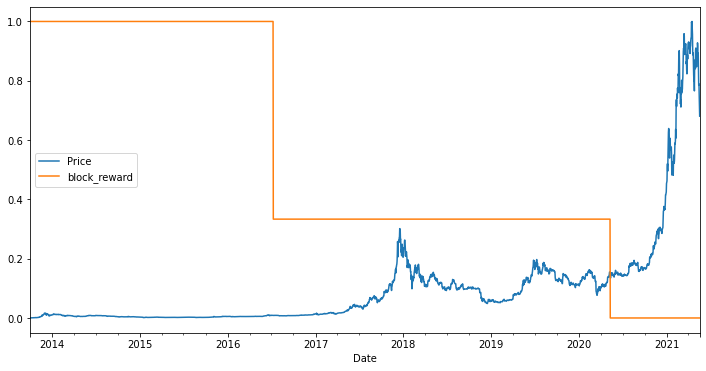

In [37]:
from sklearn.preprocessing import minmax_scale
scaled_price_df = pd.DataFrame(minmax_scale(price_df[['Price', 'block_reward']]), columns=price_df.columns, index=price_df.index)
scaled_price_df.plot(figsize=(12, 6))

### Making windowed datasets

In [38]:
WINDOW_SIZE = 7
HORIZON = 1
price_df_windowed = price_df.copy()

In [39]:
for i in range(WINDOW_SIZE):
    price_df_windowed['Price+{}'.format(i+1)] = price_df_windowed['Price'].shift(periods=i+1)
price_df_windowed

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654990,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,25,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,25,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,25,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [40]:
X = price_df_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = price_df_windowed.dropna()['Price'].astype(np.float32)
X.shape, y.shape

((2780, 8), (2780,))

In [41]:
split_size = int(0.8*len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2224, 8), (2224,), (556, 8), (556,))

### Build model

In [68]:
tb_callback6 = create_tensorboard_callback(dir_name='timeseries_logs/model_logs', experiment_name='model6_dense_window7_horizon1_multivariate')
mc_callback6 = create_model_checkpoint_callback(save_path='timeseries_logs/model_checkpoint', model_name='model6_dense_window7_horizon1_multivariate')

model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON)
], name='model_6')

model_6.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_6.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128, validation_data=(X_test, y_test),
            callbacks=[tb_callback6, mc_callback6])

Saving TensorBoard log files to: timeseries_logs/model_logs/model6_dense_window7_horizon1_multivariate/20220701-141842
Saving model checkpoint to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate
Epoch 1/100
 1/18 [>.............................] - ETA: 15s - loss: 4619.9810 - mae: 4619.9810 - mse: 48725468.0000INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 2s 38ms/step - loss: 2344.0779 - mae: 2344.0779 - mse: 15808140.0000 - val_loss: 2496.9785 - val_mae: 2496.9785 - val_mse: 13912493.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 344.8185 - mae: 344.8185 - mse: 447094.0625INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 383.7077 - mae: 383.7077 - mse: 549238.8125 - val_loss: 1519.3303 - val_mae: 1519.3303 - val_mse: 6054630.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 285.3803 - mae: 285.3803 - mse: 325244.2500INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 250.2997 - mae: 250.2997 - mse: 295710.3125 - val_loss: 1141.8098 - val_mae: 1141.8098 - val_mse: 4326885.5000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 131.4475 - mae: 131.4475 - mse: 75914.4297INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 205.7991 - mae: 205.7991 - mse: 212072.4688 - val_loss: 1105.7111 - val_mae: 1105.7111 - val_mse: 3926657.5000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 159.7269 - mae: 159.7269 - mse: 158092.1406INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 195.5550 - mae: 195.5550 - mse: 199956.6250 - val_loss: 1075.0659 - val_mae: 1075.0659 - val_mse: 3632492.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 187.1398 - mae: 187.1398 - mse: 178756.6562INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 182.4598 - mae: 182.4598 - mse: 178574.6250 - val_loss: 995.2174 - val_mae: 995.2174 - val_mse: 3322251.7500
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 158.4412 - mae: 158.4412 - mse: 89801.1094INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 180.5676 - mae: 180.5676 - mse: 170442.6406 - val_loss: 989.2410 - val_mae: 989.2410 - val_mse: 3168931.0000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 147.3085 - mae: 147.3085 - mse: 116405.2969INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 172.3398 - mae: 172.3398 - mse: 160671.8438 - val_loss: 988.1755 - val_mae: 988.1755 - val_mse: 3071724.7500
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 193.3084 - mae: 193.3084 - mse: 215187.6875INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 168.1772 - mae: 168.1772 - mse: 152760.1875 - val_loss: 982.9274 - val_mae: 982.9274 - val_mse: 2965005.2500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 151.6324 - mae: 151.6324 - mse: 126863.0547INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 1s 53ms/step - loss: 163.7906 - mae: 163.7906 - mse: 146273.0312 - val_loss: 894.1046 - val_mae: 894.1046 - val_mse: 2718291.2500
Epoch 11/100
18/18 [==============================] - 0s 2ms/step - loss: 159.7812 - mae: 159.7812 - mse: 137839.3750 - val_loss: 908.3221 - val_mae: 908.3221 - val_mse: 2612645.2500
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 135.5940 - mae: 135.5940 - mse: 76747.9844INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 156.5786 - mae: 156.5786 - mse: 133099.2188 - val_loss: 847.2408 - val_mae: 847.2408 - val_mse: 2474425.5000
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 158.6643 - mae: 158.6643 - mse: 106167.6719INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 153.4713 - mae: 153.4713 - mse: 128484.4297 - val_loss: 839.1199 - val_mae: 839.1199 - val_mse: 2315978.5000
Epoch 14/100
18/18 [==============================] - 0s 3ms/step - loss: 152.2686 - mae: 152.2686 - mse: 124967.0469 - val_loss: 841.6476 - val_mae: 841.6475 - val_mse: 2248554.2500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 170.0437 - mae: 170.0437 - mse: 185244.2188INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 143.8949 - mae: 143.8949 - mse: 114886.1250 - val_loss: 806.6817 - val_mae: 806.6817 - val_mse: 2113307.2500
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 132.2699 - mae: 132.2699 - mse: 86576.6953INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 19ms/step - loss: 142.0532 - mae: 142.0532 - mse: 111040.5469 - val_loss: 784.9200 - val_mae: 784.9200 - val_mse: 2013027.5000
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 138.2311 - mae: 138.2311 - mse: 116292.4375INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 138.4028 - mae: 138.4028 - mse: 106358.3125 - val_loss: 752.7158 - val_mae: 752.7158 - val_mse: 1925710.0000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 116.6070 - mae: 116.6070 - mse: 56928.0156INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 138.0253 - mae: 138.0253 - mse: 105778.4531 - val_loss: 737.5327 - val_mae: 737.5327 - val_mse: 1849974.1250
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 111.1056 - mae: 111.1056 - mse: 49184.5000INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 133.3843 - mae: 133.3843 - mse: 99710.2969 - val_loss: 730.1488 - val_mae: 730.1488 - val_mse: 1769356.6250
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 152.4208 - mae: 152.4208 - mse: 145769.2812INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 132.8877 - mae: 132.8877 - mse: 98093.9688 - val_loss: 711.6353 - val_mae: 711.6353 - val_mse: 1700867.2500
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 141.3151 - mae: 141.3151 - mse: 110470.9375INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 128.1280 - mae: 128.1280 - mse: 94132.9453 - val_loss: 707.9296 - val_mae: 707.9296 - val_mse: 1658317.0000
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 136.7036 - mae: 136.7036 - mse: 83000.6484INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 128.4436 - mae: 128.4436 - mse: 93094.1250 - val_loss: 686.6192 - val_mae: 686.6192 - val_mse: 1615523.2500
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 134.1233 - mae: 134.1233 - mse: 137763.3281INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 125.8454 - mae: 125.8454 - mse: 91112.2656 - val_loss: 677.1021 - val_mae: 677.1021 - val_mse: 1578988.5000
Epoch 24/100
18/18 [==============================] - 0s 2ms/step - loss: 125.8009 - mae: 125.8009 - mse: 90199.8984 - val_loss: 679.8853 - val_mae: 679.8853 - val_mse: 1539669.6250
Epoch 25/100
18/18 [==============================] - 0s 2ms/step - loss: 124.4979 - mae: 124.4979 - mse: 88778.2578 - val_loss: 682.8218 - val_mae: 682.8218 - val_mse: 1533735.1250
Epoch 26/100
18/18 [==============================] - 0s 2ms/step - loss: 122.7647 - mae: 122.7647 - mse: 85558.3438 - val_loss: 679.6849 - val_mae: 679.6849 - val_mse: 1578538.1250
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 126.4213 - mae: 126.4213 - mse: 76174.5469INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 122.7357 - mae: 122.7357 - mse: 85743.5938 - val_loss: 660.1064 - val_mae: 660.1064 - val_mse: 1458883.5000
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 145.4300 - mae: 145.4300 - mse: 144580.1562INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 120.9978 - mae: 120.9978 - mse: 84331.3281 - val_loss: 642.6849 - val_mae: 642.6849 - val_mse: 1423136.3750
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 82.8621 - mae: 82.8621 - mse: 43508.6133INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 124.8764 - mae: 124.8764 - mse: 87359.2734 - val_loss: 642.1043 - val_mae: 642.1043 - val_mse: 1432001.7500
Epoch 30/100
18/18 [==============================] - 0s 2ms/step - loss: 127.8579 - mae: 127.8579 - mse: 88816.6875 - val_loss: 697.8040 - val_mae: 697.8040 - val_mse: 1545812.7500
Epoch 31/100
18/18 [==============================] - 0s 2ms/step - loss: 125.0672 - mae: 125.0672 - mse: 87710.4531 - val_loss: 697.6331 - val_mae: 697.6331 - val_mse: 1541511.8750
Epoch 32/100
18/18 [==============================] - 0s 2ms/step - loss: 117.2159 - mae: 117.2159 - mse: 81333.9062 - val_loss: 683.6501 - val_mae: 683.6501 - val_mse: 1547576.7500
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 98.0263 - mae: 98.0263 - mse: 35313.2578INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 120.5643 - mae: 120.5643 - mse: 80132.1953 - val_loss: 621.7449 - val_mae: 621.7449 - val_mse: 1349947.8750
Epoch 34/100
18/18 [==============================] - 0s 2ms/step - loss: 115.2079 - mae: 115.2079 - mse: 78833.5938 - val_loss: 622.1971 - val_mae: 622.1971 - val_mse: 1354317.8750
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 96.1440 - mae: 96.1440 - mse: 42585.7188INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 114.2194 - mae: 114.2194 - mse: 78232.7734 - val_loss: 614.7637 - val_mae: 614.7637 - val_mse: 1314895.0000
Epoch 36/100
18/18 [==============================] - 0s 2ms/step - loss: 114.4039 - mae: 114.4039 - mse: 78966.0234 - val_loss: 663.6591 - val_mae: 663.6591 - val_mse: 1429119.1250
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 119.9991 - mae: 119.9991 - mse: 52243.8203INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 118.2394 - mae: 118.2394 - mse: 80663.3281 - val_loss: 612.2488 - val_mae: 612.2488 - val_mse: 1318613.5000
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 118.8767 - mae: 118.8767 - mse: 103232.6875INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 113.3665 - mae: 113.3665 - mse: 78253.9531 - val_loss: 605.6031 - val_mae: 605.6031 - val_mse: 1295932.3750
Epoch 39/100
18/18 [==============================] - 0s 2ms/step - loss: 116.8143 - mae: 116.8143 - mse: 79904.3750 - val_loss: 622.4692 - val_mae: 622.4692 - val_mse: 1318909.6250
Epoch 40/100
18/18 [==============================] - 0s 2ms/step - loss: 118.0296 - mae: 118.0296 - mse: 79031.7422 - val_loss: 660.7775 - val_mae: 660.7775 - val_mse: 1413622.7500
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 154.6321 - mae: 154.6321 - mse: 124583.8125INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 19ms/step - loss: 119.4315 - mae: 119.4315 - mse: 79716.0156 - val_loss: 600.5131 - val_mae: 600.5131 - val_mse: 1278404.3750
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 85.8644 - mae: 85.8644 - mse: 50666.7266INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 115.7295 - mae: 115.7295 - mse: 79171.3828 - val_loss: 597.4108 - val_mae: 597.4108 - val_mse: 1263412.5000
Epoch 43/100
18/18 [==============================] - 0s 2ms/step - loss: 112.7419 - mae: 112.7419 - mse: 74719.5938 - val_loss: 698.4487 - val_mae: 698.4487 - val_mse: 1545983.3750
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 126.8311 - mae: 126.8311 - mse: 74808.8203INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 115.1266 - mae: 115.1266 - mse: 76260.8047 - val_loss: 593.4367 - val_mae: 593.4367 - val_mse: 1251494.8750
Epoch 45/100
18/18 [==============================] - 0s 2ms/step - loss: 112.3434 - mae: 112.3434 - mse: 76108.8516 - val_loss: 601.5011 - val_mae: 601.5011 - val_mse: 1261405.8750
Epoch 46/100
18/18 [==============================] - 0s 2ms/step - loss: 115.4634 - mae: 115.4634 - mse: 76418.7031 - val_loss: 620.3173 - val_mae: 620.3173 - val_mse: 1315222.1250
Epoch 47/100
18/18 [==============================] - 0s 2ms/step - loss: 112.2518 - mae: 112.2518 - mse: 74497.1797 - val_loss: 638.8861 - val_mae: 638.8861 - val_mse: 1360701.1250
Epoch 48/100
18/18 [==============================] - 0s 2ms/step - loss: 114.6832 - mae: 114.6832 - mse: 77220.1641 - val_loss: 613.6644 - val_mae: 613.6644 - val_mse: 1295572.6250
Epoch 49/100
18/18 [==============================] - 0s 2ms/step - loss: 112.0024 - mae: 112.0024 - m

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 21ms/step - loss: 110.7159 - mae: 110.7159 - mse: 74782.5781 - val_loss: 587.5698 - val_mae: 587.5698 - val_mse: 1230115.7500
Epoch 51/100
18/18 [==============================] - 0s 2ms/step - loss: 110.4852 - mae: 110.4852 - mse: 74327.5625 - val_loss: 616.8409 - val_mae: 616.8409 - val_mse: 1298141.0000
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 154.9796 - mae: 154.9796 - mse: 148628.5312INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 110.3348 - mae: 110.3348 - mse: 74895.8203 - val_loss: 587.1471 - val_mae: 587.1471 - val_mse: 1225530.2500
Epoch 53/100
18/18 [==============================] - 0s 3ms/step - loss: 109.8445 - mae: 109.8445 - mse: 72903.5938 - val_loss: 669.5276 - val_mae: 669.5276 - val_mse: 1434809.7500
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 93.9319 - mae: 93.9319 - mse: 40711.4102INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 112.1674 - mae: 112.1674 - mse: 74677.3828 - val_loss: 585.4335 - val_mae: 585.4335 - val_mse: 1226011.1250
Epoch 55/100
18/18 [==============================] - 0s 2ms/step - loss: 110.3465 - mae: 110.3465 - mse: 72275.1953 - val_loss: 601.3345 - val_mae: 601.3345 - val_mse: 1247862.1250
Epoch 56/100
18/18 [==============================] - 0s 2ms/step - loss: 109.2843 - mae: 109.2843 - mse: 72073.5781 - val_loss: 614.0394 - val_mae: 614.0394 - val_mse: 1274925.1250
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 105.7256 - mae: 105.7256 - mse: 90565.5234INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 112.5606 - mae: 112.5606 - mse: 75507.2031 - val_loss: 581.1583 - val_mae: 581.1583 - val_mse: 1209201.0000
Epoch 58/100
 1/18 [>.............................] - ETA: 0s - loss: 92.6007 - mae: 92.6007 - mse: 74361.5938INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 110.0272 - mae: 110.0272 - mse: 72861.4375 - val_loss: 579.1775 - val_mae: 579.1775 - val_mse: 1204495.1250
Epoch 59/100
18/18 [==============================] - 0s 2ms/step - loss: 111.9807 - mae: 111.9807 - mse: 75189.3047 - val_loss: 582.3688 - val_mae: 582.3688 - val_mse: 1208996.5000
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 106.1296 - mae: 106.1296 - mse: 60522.9219INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 110.3564 - mae: 110.3564 - mse: 71951.0078 - val_loss: 576.7506 - val_mae: 576.7506 - val_mse: 1199810.1250
Epoch 61/100
18/18 [==============================] - 0s 2ms/step - loss: 108.4869 - mae: 108.4869 - mse: 70828.1094 - val_loss: 604.3797 - val_mae: 604.3797 - val_mse: 1249277.8750
Epoch 62/100
18/18 [==============================] - 0s 2ms/step - loss: 110.0653 - mae: 110.0653 - mse: 72893.0391 - val_loss: 589.9269 - val_mae: 589.9269 - val_mse: 1219463.6250
Epoch 63/100
18/18 [==============================] - 0s 2ms/step - loss: 108.3369 - mae: 108.3369 - mse: 72262.5703 - val_loss: 577.9587 - val_mae: 577.9587 - val_mse: 1197291.6250
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 84.2355 - mae: 84.2355 - mse: 29149.2109INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 19ms/step - loss: 108.5086 - mae: 108.5086 - mse: 71564.3438 - val_loss: 574.6141 - val_mae: 574.6141 - val_mse: 1192961.1250
Epoch 65/100
18/18 [==============================] - 0s 2ms/step - loss: 108.8886 - mae: 108.8886 - mse: 72435.8594 - val_loss: 579.2255 - val_mae: 579.2255 - val_mse: 1202481.7500
Epoch 66/100
18/18 [==============================] - 0s 2ms/step - loss: 111.9965 - mae: 111.9965 - mse: 72952.3516 - val_loss: 665.4543 - val_mae: 665.4543 - val_mse: 1407649.6250
Epoch 67/100
18/18 [==============================] - 0s 2ms/step - loss: 112.5537 - mae: 112.5537 - mse: 74506.2109 - val_loss: 637.0578 - val_mae: 637.0578 - val_mse: 1320298.7500
Epoch 68/100
18/18 [==============================] - 0s 2ms/step - loss: 108.9452 - mae: 108.9452 - mse: 72279.0000 - val_loss: 574.7448 - val_mae: 574.7448 - val_mse: 1190375.0000
Epoch 69/100
18/18 [==============================] - 0s 2ms/step - loss: 106.8676 - mae: 106.8676 - m

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 19ms/step - loss: 114.1948 - mae: 114.1948 - mse: 72403.7188 - val_loss: 574.1252 - val_mae: 574.1252 - val_mse: 1182090.6250
Epoch 79/100
 1/18 [>.............................] - ETA: 0s - loss: 129.8217 - mae: 129.8217 - mse: 106367.3594INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 110.3503 - mae: 110.3503 - mse: 70686.4062 - val_loss: 568.5180 - val_mae: 568.5180 - val_mse: 1169413.6250
Epoch 80/100
18/18 [==============================] - 0s 2ms/step - loss: 109.2591 - mae: 109.2591 - mse: 70922.7109 - val_loss: 599.8063 - val_mae: 599.8063 - val_mse: 1227932.8750
Epoch 81/100
18/18 [==============================] - 0s 2ms/step - loss: 107.7264 - mae: 107.7264 - mse: 70962.5000 - val_loss: 628.5653 - val_mae: 628.5653 - val_mse: 1299716.5000
Epoch 82/100
18/18 [==============================] - 0s 2ms/step - loss: 109.3919 - mae: 109.3919 - mse: 68191.3125 - val_loss: 580.1898 - val_mae: 580.1898 - val_mse: 1186335.1250
Epoch 83/100
18/18 [==============================] - 0s 2ms/step - loss: 106.4941 - mae: 106.4941 - mse: 70187.5625 - val_loss: 583.9045 - val_mae: 583.9045 - val_mse: 1194141.6250
Epoch 84/100
18/18 [==============================] - 0s 2ms/step - loss: 109.7090 - mae: 109.7090 - m

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 107.4660 - mae: 107.4660 - mse: 69138.6641 - val_loss: 566.9989 - val_mae: 566.9989 - val_mse: 1163572.8750
Epoch 87/100
18/18 [==============================] - 0s 2ms/step - loss: 107.5577 - mae: 107.5577 - mse: 70138.4609 - val_loss: 679.5017 - val_mae: 679.5017 - val_mse: 1431040.0000
Epoch 88/100
18/18 [==============================] - 0s 2ms/step - loss: 111.3191 - mae: 111.3191 - mse: 73901.0312 - val_loss: 657.6801 - val_mae: 657.6801 - val_mse: 1359194.7500
Epoch 89/100
18/18 [==============================] - 0s 2ms/step - loss: 122.5257 - mae: 122.5257 - mse: 80324.3828 - val_loss: 647.5290 - val_mae: 647.5290 - val_mse: 1333715.7500
Epoch 90/100
18/18 [==============================] - 0s 2ms/step - loss: 114.2919 - mae: 114.2919 - mse: 74329.2500 - val_loss: 681.8171 - val_mae: 681.8171 - val_mse: 1437552.0000
Epoch 91/100
18/18 [==============================] - 0s 2ms/step - loss: 110.7645 - mae: 110.7645 - m

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 19ms/step - loss: 107.8527 - mae: 107.8527 - mse: 70903.7344 - val_loss: 566.5593 - val_mae: 566.5593 - val_mse: 1160554.8750
Epoch 96/100
18/18 [==============================] - 0s 2ms/step - loss: 108.6513 - mae: 108.6513 - mse: 71027.4297 - val_loss: 620.9708 - val_mae: 620.9708 - val_mse: 1280122.5000
Epoch 97/100
18/18 [==============================] - 0s 2ms/step - loss: 108.0850 - mae: 108.0850 - mse: 70195.5859 - val_loss: 569.6989 - val_mae: 569.6989 - val_mse: 1163240.3750
Epoch 98/100
18/18 [==============================] - 0s 2ms/step - loss: 107.0715 - mae: 107.0715 - mse: 69967.7734 - val_loss: 586.1089 - val_mae: 586.1089 - val_mse: 1204235.7500
Epoch 99/100
18/18 [==============================] - 0s 2ms/step - loss: 109.4018 - mae: 109.4018 - mse: 70068.6094 - val_loss: 571.7068 - val_mae: 571.7068 - val_mse: 1165657.6250
Epoch 100/100
 1/18 [>.............................] - ETA: 0s - loss: 117.3685 - mae: 117.3685 - mse:

INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate/assets


18/18 [==============================] - 0s 20ms/step - loss: 107.7641 - mae: 107.7641 - mse: 69576.9844 - val_loss: 566.3810 - val_mae: 566.3810 - val_mse: 1158492.5000


In [42]:
best_model_6 = tf.keras.models.load_model('timeseries_logs/model_checkpoint/model6_dense_window7_horizon1_multivariate')
model6_pred = best_model_6.predict(X_test)
model6_pred.shape, test_labels.shape

18/18 [==============================] - 0s 750us/step


((556, 1), (556, 1))

In [43]:
model6_res = evaluate_preds(test_labels[:, 0], model6_pred[:, 0])
model6_res

{'mae': 566.3809,
 'mse': 1158492.4,
 'rmse': 1076.3329,
 'mape': 2.5376108,
 'mase': 0.9949744}

## Model 7: N-BEATS
https://arxiv.org/pdf/1905.10437.pdf

In [45]:
from NBeats_model.model import NBeatsBlock

In [46]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(7, 8)

### Fast loading datasets

In [47]:
WINDOW_SIZE = 7
HORIZON = 1
if 'block_reward' in price_df.columns:
    price_df = price_df.drop('block_reward', axis=1)
price_df_windowed = price_df.copy()

In [48]:
for i in range(WINDOW_SIZE):
    price_df_windowed['Price+{}'.format(i+1)] = price_df_windowed['Price'].shift(periods=i+1)
X = price_df_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = price_df_windowed.dropna()['Price'].astype(np.float32)
X.shape, y.shape

((2780, 7), (2780,))

In [49]:
split_size = int(0.8*len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2224, 7), (2224,), (556, 7), (556,))

In [50]:
BATCH_SIZE = 1024
train_feat_data = tf.data.Dataset.from_tensor_slices(X_train)
train_label_data = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_feat_data, train_label_data))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_feat_data = tf.data.Dataset.from_tensor_slices(X_test)
test_label_data = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_feat_data, test_label_data))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### Build model

In [ ]:
tf.random.set_seed(42)
tb_callback7 = create_tensorboard_callback(dir_name='timeseries_logs/model_logs', experiment_name='model7_nbeats_window7_horizon1')
mc_callback7 = create_model_checkpoint_callback(save_path='timeseries_logs/model_checkpoint', model_name='model7_nbeats_window7_horizon1')
es_callback7 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
rl_callback7 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, theta_size=THETA_SIZE, horizon=HORIZON,
                                 n_neurons=N_NEURONS, n_layers=N_LAYERS, name='Initial_block')

stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name='stack_input')

residuals, forecast = nbeats_block_layer(stack_input)

for i, _ in enumerate(range(N_STACKS-1)):
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE, theta_size=THETA_SIZE, horizon=HORIZON,
                                           n_neurons=N_NEURONS, n_layers=N_LAYERS, name='NBeatsBlock_{}'.format(i))(residuals)
    residuals = tf.keras.layers.subtract([residuals, backcast], name='subtract_{}'.format(i))
    forecast = tf.keras.layers.add([forecast, block_forecast], name='add_{}'.format(i))
    
model_7 = tf.keras.Model(stack_input, forecast, name='model_7')
model_7.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_7.fit(train_dataset, epochs=N_EPOCHS, verbose=0, validation_data=test_dataset,
            callbacks=[tb_callback7, mc_callback7, es_callback7, rl_callback7])

Saving TensorBoard log files to: timeseries_logs/model_logs/model7_nbeats_window7_horizon1/20220701-165449
Saving model checkpoint to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1
Layer NBeatsBlock has arguments ['self', 'input_size', 'theta_size', 'horizon', 'n_neurons', 'n_layers']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Layer NBeatsBlock has arguments ['self', 'input_size', 'theta_size', 'horizon', 'n_neurons', 'n_layers']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1/assets


In [51]:
best_model_7 = tf.keras.models.load_model('timeseries_logs/model_checkpoint/model7_nbeats_window7_horizon1')
model7_pred = best_model_7.predict(test_dataset)
model7_pred.shape, y_test.shape

1/1 [==============================] - 1s 1s/step


((556, 1), (556,))

In [53]:
model7_res = evaluate_preds(test_labels[:, 0], model7_pred[:, 0])
model7_res

{'mae': 579.57465,
 'mse': 1209184.9,
 'rmse': 1099.6294,
 'mape': 2.5978236,
 'mase': 1.0181521}

In [54]:
from tensorflow.keras.utils import plot_model

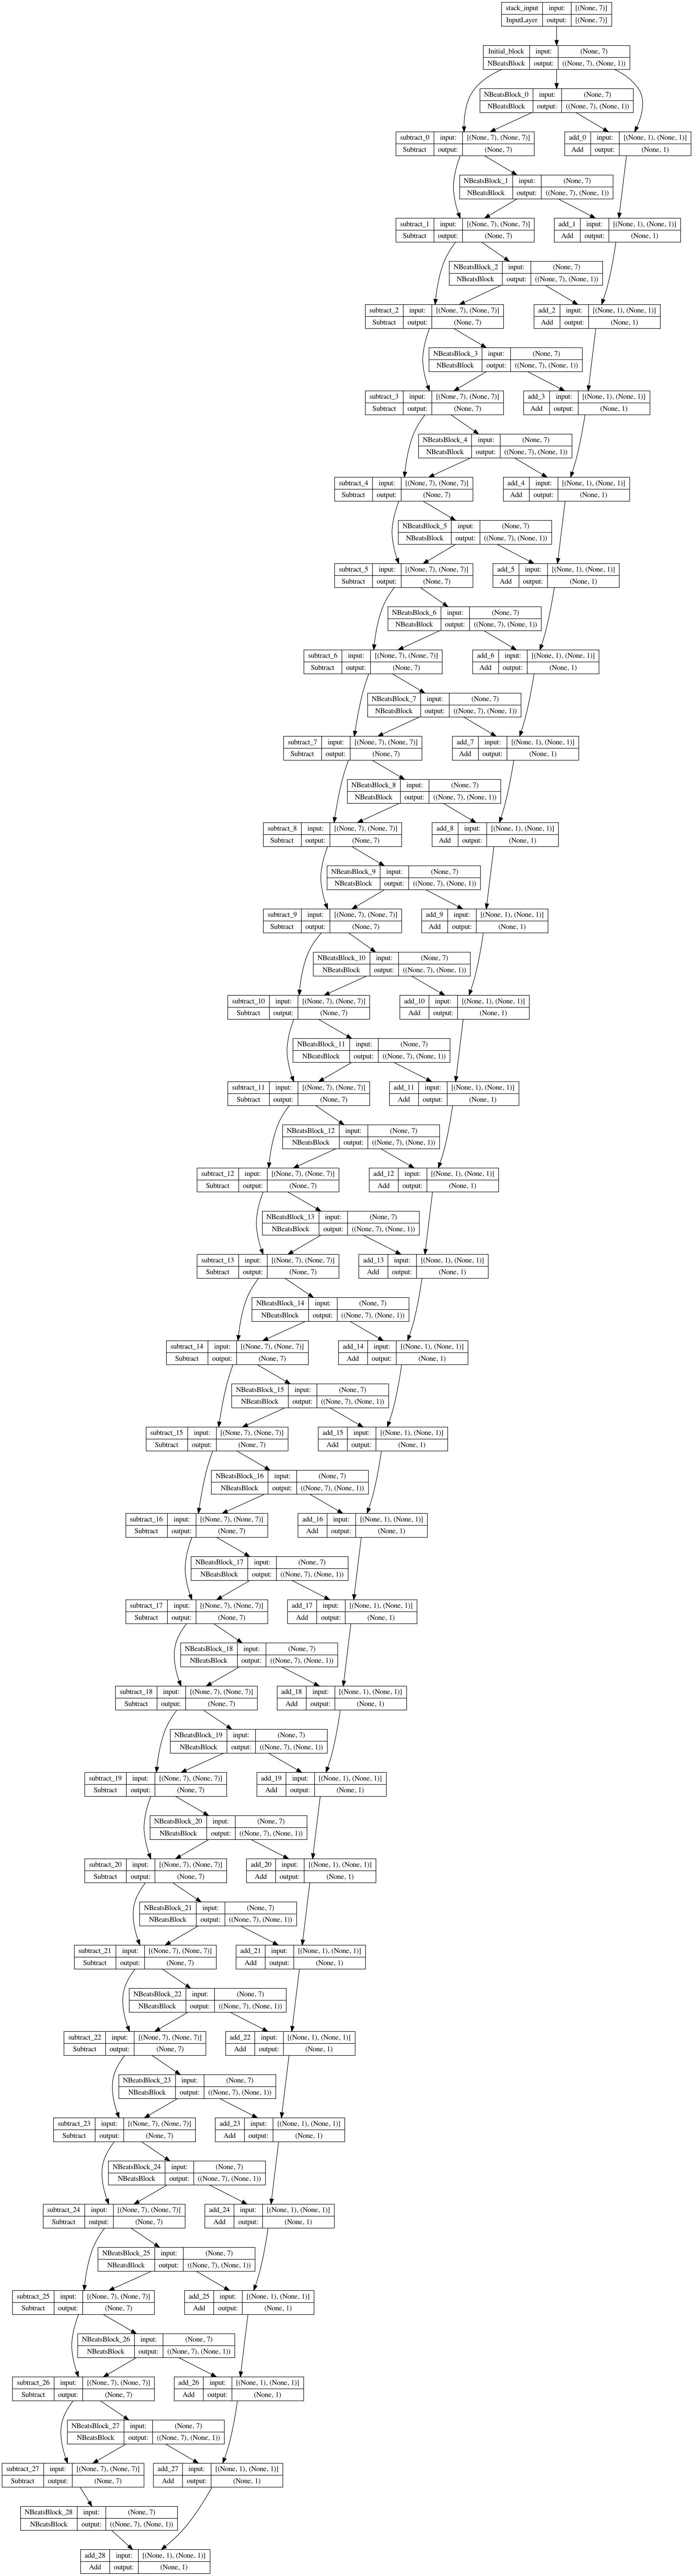

In [57]:
plot_model(best_model_7, show_shapes=True)

## Model 8: Ensemble

In [59]:
HORIZON, WINDOW_SIZE

(1, 7)

In [62]:
def get_ensemble_models(horizon=HORIZON, train_data=train_dataset, test_data=test_dataset, num_iter=10, num_epochs=1000, loss_fns=['mae', 'mse', 'mape']):
    ensemble_models = []
    for i in range(num_iter):
        for loss_function in loss_fns:
            print('Loss: {}, epochs: {}, model number {}'.format(loss_function, num_epochs, i))
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                tf.keras.layers.Dense(horizon),
            ])
            model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
            model.fit(train_data, epochs=num_epochs, verbose=0, validation_data=test_data, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                                                                                                      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)])
            ensemble_models.append(model)
    return ensemble_models

In [63]:
%%time
ensemble_models = get_ensemble_models(num_iter=5, num_epochs=1000)

Loss: mae, epochs: 1000, model number 0
Loss: mse, epochs: 1000, model number 0

Epoch 180: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 280: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Loss: mape, epochs: 1000, model number 0

Epoch 298: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 398: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Loss: mae, epochs: 1000, model number 1
Loss: mse, epochs: 1000, model number 1

Epoch 404: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 504: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Loss: mape, epochs: 1000, model number 1

Epoch 153: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Loss: mae, epochs: 1000, model number 2

Epoch 948: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Loss: mse, epochs: 1000, model number 2

Epoch 724: ReduceLROnPlateau reducing

In [67]:
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        pred = model.predict(data)
        ensemble_preds.append(pred)
    return tf.constant(tf.squeeze(ensemble_preds))

In [68]:
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

1/1 [==============================] - 0s 30ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8718.671,  8617.015,  8980.566, ..., 49357.707, 48048.96 ,
        45028.582],
       [ 8718.217,  8786.669,  9041.797, ..., 49999.453, 47759.133,
        46259.24 ],
       [ 8778.487,  8740.482,  9030.87 , ..., 49759.71 , 47945.25 ,
        45648.84 ],
       ...,
       [ 8783.477,  8787.966,  9054.069, ..., 50450.586, 48531.008,
        47127.004],
       [ 8817.724,  8754.616,  9040.469, ..., 49770.3  , 48569.906,
        45438.81 ],
       [ 8798.142,  8709.502,  8993.449, ..., 49828.234, 48320.33 ,
        46540.438]], dtype=float32)>

In [75]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_mean.shape, ensemble_median.shape

(TensorShape([556]), (556,))

In [76]:
model8_res_mean = evaluate_preds(test_labels[:, 0], ensemble_mean)
model8_res_median = evaluate_preds(test_labels[:, 0], ensemble_median)
model8_res_mean, model8_res_median

({'mae': 569.1213,
  'mse': 1146009.8,
  'rmse': 1070.5184,
  'mape': 2.5737722,
  'mase': 0.99978846},
 {'mae': 569.3734,
  'mse': 1142227.1,
  'rmse': 1068.7502,
  'mape': 2.5684826,
  'mase': 1.0002314})

### Interval estimation

In [77]:
def get_upper_lower(preds):
    std = tf.math.reduce_std(preds, axis=0)
    interval = 1.96 * std
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval
    return lower, upper

In [80]:
lower, upper = get_upper_lower(ensemble_preds)
lower.shape, upper.shape

(TensorShape([556]), TensorShape([556]))

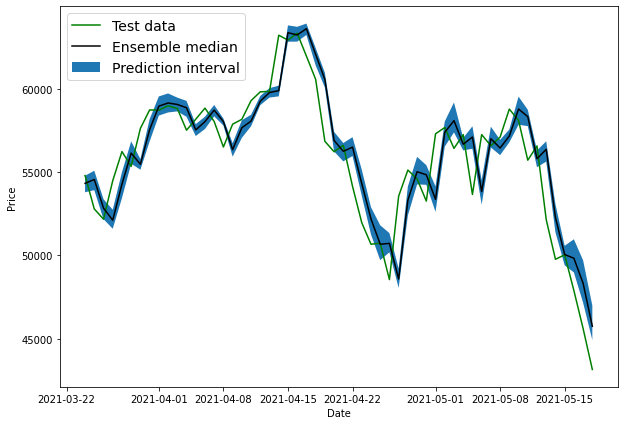

In [83]:
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='Test data')
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label='Ensemble median')
plt.xlabel('Date')
plt.ylabel('Price')
plt.fill_between(X_test.index[offset:], lower[offset:], upper[offset:], label='Prediction interval')
plt.legend(loc='upper left', fontsize=14)

## Model 9: Future prediction

### Prepare data

In [85]:
X_all = price_df_windowed.dropna().drop(['Price'], axis=1).to_numpy()
y_all = price_df_windowed.dropna()['Price'].to_numpy()
X_all.shape, y_all.shape

((2780, 7), (2780,))

In [87]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))
dataset_all = dataset_all.batch(batch_size=1024).prefetch(tf.data.AUTOTUNE)
dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### Build model

In [89]:
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON),
], name='model_9')
model_9.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_9.fit(dataset_all, epochs=100, verbose=0)

### Make prediction and plot

In [90]:
INTO_FUTURES = 14

In [91]:
def make_future_forecast(values, model, into_futures, window_size=WINDOW_SIZE):
    future_forecasts = []
    last_window = values[-window_size:]
    for _ in range(into_futures):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print('Prediction: {} -> {}'.format(last_window, tf.squeeze(future_pred).numpy()))
        
        future_forecasts.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred)[-window_size:]
    return future_forecasts

In [94]:
future_forecast = make_future_forecast(y_all, model_9, INTO_FUTURES)

1/1 [==============================] - 0s 14ms/step
Prediction: [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> 55598.05078125
1/1 [==============================] - 0s 21ms/step
Prediction: [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55598.05078125] -> 49804.89453125
1/1 [==============================] - 0s 13ms/step
Prediction: [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55598.05078125 49804.89453125] -> 50905.94140625
1/1 [==============================] - 0s 13ms/step
Prediction: [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55598.05078125 49804.89453125 50905.94140625] -> 49566.7109375
1/1 [==============================] - 0s 13ms/step
Prediction: [47885.62525472 45604.61575361 43144.47129086 55598.05078125
 49804.89453125 50905.94140625 49566.7109375 ] -> 45223.08203125
1/1 [==============================] - 0s 16ms/step

In [95]:
def get_future_dates(start_date, into_futures, offset=1):
    start_date = start_date + np.timedelta64(offset, 'D')
    end_date = start_date + np.timedelta64(into_futures, 'D')
    return np.arange(start_date, end_date, dtype='datetime64[D]')

In [97]:
future_dates = get_future_dates(price_df.index[-1], INTO_FUTURES)

In [100]:
future_dates = np.insert(future_dates, 0, price_df.index[-1])
future_forecast = np.insert(future_forecast, 0, price_df['Price'][-1])

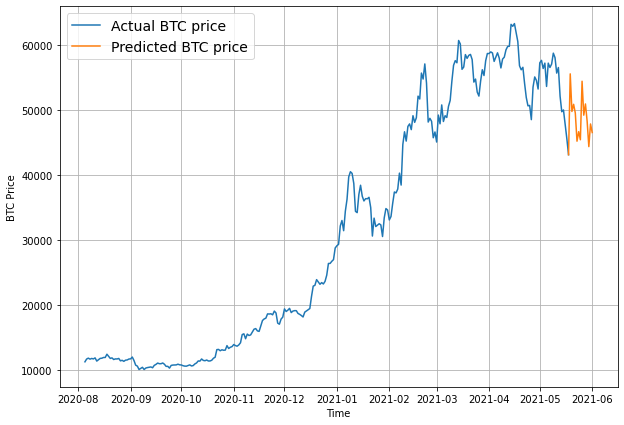

In [101]:
plt.figure(figsize=(10, 7))
plot_time_series(price_df.index, price_df['Price'], start=2500, format='-', label='Actual BTC price')
plot_time_series(future_dates, future_forecast, format='-', label='Predicted BTC price')

## Model 10: Turkey problem

In [104]:
price_turkey = price_df['Price'].to_numpy()
price_turkey[-1] = price_turkey[-1]/100

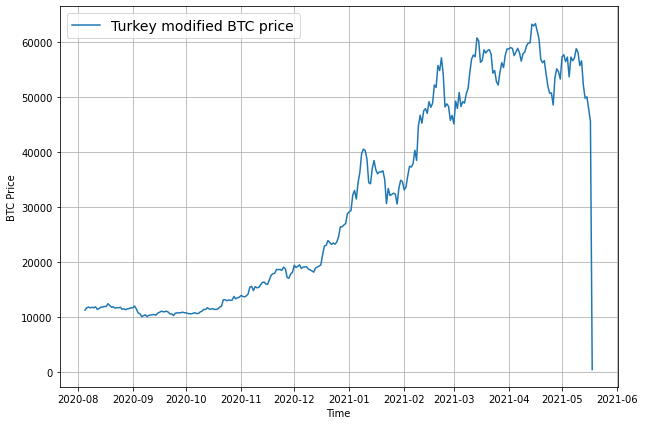

In [108]:
plt.figure(figsize=(10, 7))
plot_time_series(price_df.index, price_turkey, format='-', start=2500, label='Turkey modified BTC price')

In [109]:
HORIZON, WINDOW_SIZE

(1, 7)

In [110]:
full_windows, full_labels = make_windows(price_turkey, window_size=WINDOW_SIZE, horizon=HORIZON)
X_train, X_test, y_train, y_test = split_windowed_data(full_windows, full_labels)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [111]:
tb_callback10 = create_tensorboard_callback(dir_name='timeseries_logs/model_logs', experiment_name='model10_dense_window7_horizon1_turkey')
mc_callback10 = create_model_checkpoint_callback(save_path='timeseries_logs/model_checkpoint', model_name='model10_dense_window7_horizon1_turkey')

model_10 = tf.keras.models.clone_model(best_model_1)
model_10._name = 'model_10'
model_10.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])
model_10.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=128, validation_data=(X_test, y_test), callbacks=[tb_callback10, mc_callback10])

Saving TensorBoard log files to: timeseries_logs/model_logs/model10_dense_window7_horizon1_turkey/20220704-153934
Saving model checkpoint to: timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey
INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey/assets
INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey/assets
INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey/assets
INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey/assets
INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey/assets
INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey/assets
INFO:tensorflow:Assets written to: timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey/ass

In [112]:
best_model_10 = tf.keras.models.load_model('timeseries_logs/model_checkpoint/model10_dense_window7_horizon1_turkey')
model10_pred = best_model_10.predict(X_test)
model10_pred.shape, y_test.shape

18/18 [==============================] - 0s 831us/step


((556, 1), (556, 1))

In [113]:
model10_res = evaluate_preds(y_test[:, 0], model10_pred[:, 0])
model10_res

{'mae': 643.1806,
 'mse': 4877514.0,
 'rmse': 2208.5095,
 'mape': 21.522926,
 'mase': 0.99532413}

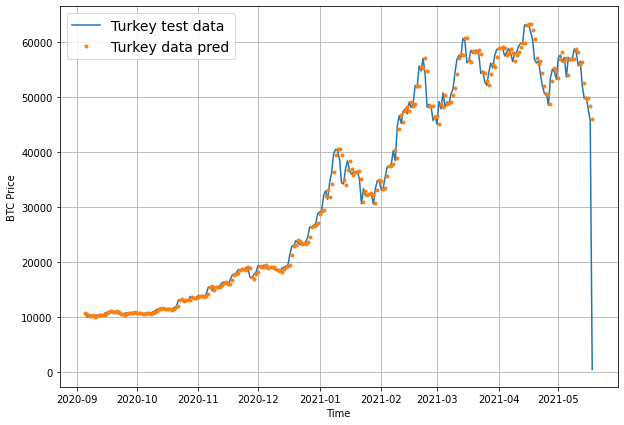

In [115]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(price_df.index[-len(X_test):], price_turkey[-len(y_test):], format='-', start=offset, label='Turkey test data')
plot_time_series(price_df.index[-len(X_test):], model10_pred[:, 0], start=offset, label='Turkey data pred')

## Compare model results

In [118]:
model_results = pd.DataFrame({
    'model0_naive': model0_res,
    'model1_dense_7_1':model1_res,
    'model2_dense_30_1': model2_res,
    'model3_dense_30_7': model3_res,
    'model4_conv1D': model4_res,
    'model5_lstm': model5_res,
    'model6_dense_multivariate': model6_res,
    'model7_nbeats': model7_res,
    'model8_ensemble': model8_res,
    'model10_turkey': model10_res
}).T
model_results

,mae,mse,rmse,mape,mase
model0_naive,567.980225,1147547.000,1071.236206,2.516525,0.999570
model1_dense_7_1,566.167114,1164192.875,1078.977661,2.541708,0.994599
model2_dense_30_1,593.489929,1194405.625,1092.888672,2.693717,1.037426
model3_dense_30_7,1231.053101,5353183.000,1419.892822,5.597612,2.190590
model4_conv1D,570.057434,1181373.875,1086.910278,2.564470,1.001433
model5_lstm,579.925781,1215544.875,1102.517456,2.603671,1.018769
model6_dense_multivariate,566.380920,1158492.375,1076.332886,2.537611,0.994974
model7_nbeats,579.574646,1209184.875,1099.629395,2.597824,1.018152
model8_ensemble,581.901062,1184501.375,1088.237671,2.640828,1.022239
model10_turkey,643.180603,4877514.000,2208.509521,21.522926,0.995324


<AxesSubplot:>

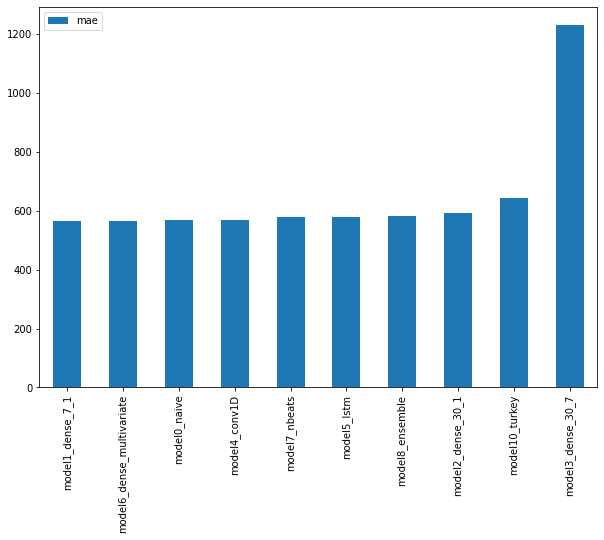

In [121]:
model_results[['mae']].sort_values(by='mae').plot(figsize=(10, 7), kind='bar')